# Background
Here, we build an OE model for the degrader-crossfeeder systems described in [Daniels et al. 2023](https://www.nature.com/articles/s41396-022-01312-w) and [Wong et al. 2023](https://www.pnas.org/doi/abs/10.1073/pnas.2217577120). The components of the model will be a degrader $\mathcal{D}$, a crossfeeder $\mathcal{C}$, a polymer $p$ and a monomer $m$.

We have sensitivity functions

$$g_\mathcal{D} (\mathbf{r}) = (1-\phi)\frac{\nu_{\mathcal{D}p} [p]}{[p] + 1}+\frac{\nu_{\mathcal{D}m} [m]}{[m] + K_{\mathcal{D}m}},$$

$$g_\mathcal{C} (\mathbf{r}) = \frac{\nu_{\mathcal{C}m} [m]}{[m] + K_{\mathcal{C}m}},$$

where $\mathbf{r} = \left(\begin{smallmatrix}[p] \\ [m]\end{smallmatrix}\right)$, and $K_{\mathcal{S}i}$ and $\nu_{\mathcal{S}i}$ respectively indicate the half-saturation constant and the maximal rate constants for the combination of species $\mathcal{S}$ and intermediate $i$. The factor $\phi$ denotes the polymer conversion fraction (i.e. the degrader utilises a fixed fraction $1-\phi$ of $p$ for its own growth and converts the remaining fraction $\phi$ into $m$).

Note that the half-saturation constant for the degrader acting on the polymer ($K_{\mathcal{D}p}$) has been removed via non-dimensionalisation, by asssuming that polymer concentrations are measured relative to it.

The gradients of these sensitivity functions are given by

$$\nabla g_\mathcal{D} (\mathbf{r}) = \begin{bmatrix}
\frac{(1-\phi)\nu_{\mathcal{D}p}}{([p] + 1)^2} \\
\frac{K_{\mathcal{D}m}\nu_{\mathcal{D}m}}{([m] + K_{\mathcal{D}m})^2}
\end{bmatrix}$$

$$\nabla g_\mathcal{C} (\mathbf{r}) = \begin{bmatrix}
0 \\
\frac{K_{\mathcal{C}m}\nu_{\mathcal{C}m}}{([m] + K_{\mathcal{C}m})^2}
\end{bmatrix}$$

We have corresponding impact functions

$$\mathbf{f}_\mathcal{D} (\mathbf{r}) = 
        \begin{pmatrix}
            -\frac{\nu_{\mathcal{D}p} [p]}{[p] + 1} \\
            \phi\frac{\nu_{\mathcal{D}p} [p]}{[p] + 1}-\frac{1}{Y_{\mathcal{D}m}}\frac{\nu_{\mathcal{D}m} [m]}{[m] + K_{\mathcal{D}m}}
        \end{pmatrix}$$
        
$$\mathbf{f}_\mathcal{C} (\mathbf{r}) = 
        \begin{pmatrix}
        0\\
        -\frac{1}{Y_{\mathcal{C}m}}\frac{\nu_{\mathcal{C}m} [m]}{[m] + K_{\mathcal{C}m}}
        \end{pmatrix}$$

where the yield constant $Y_{\mathcal{D}p}$ has likewise been eliminated via non-dimensionalisation, along with a factor specifying the number of units of metabolite produced per unit of polymer.

In the initial sections of the following, we implement these equations as sensFunc, gradSensFunc and impactFunc.

In [1]:
#Import packages used
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root

In [2]:
#Sensitivity function - rs are resource concs, specInd is the index of the species under consideration, Kms are the half-maximal velocity concentrations, Vmaxes are the maximal growth rates on saturating sugar
def sensFunc(rs,specInd,Kms,Vmaxs,degInvest):
    
    if specInd == 0: #Indicates degrader species
        return Vmaxs[0,0]*(1-degInvest)*(rs[0]/(rs[0] + Kms[0,0])) + Vmaxs[0,1]*(rs[1]/(rs[1] + Kms[0,1]))
    elif specInd == 1: #Indicates cross-feeder species
        return Vmaxs[1,1] * (rs[1]/(rs[1] + Kms[1,1]))

#Gradient of the sensitivity function in the resource space
def gradSensFunc(rs,specInd,Kms,Vmaxs,degInvest):
    sensGrad = np.zeros(rs.shape)
    
    if specInd == 0:
        sensGrad[0] = Vmaxs[0,0]*(1-degInvest)*Kms[0,0]/(rs[0]+Kms[0,0])**2
        sensGrad[1] = Vmaxs[0,1]*Kms[0,1]/(rs[1]+Kms[0,1])**2
    elif specInd == 1: 
        sensGrad[1] = Vmaxs[1,1]*Kms[1,1]/(rs[1]+Kms[1,1])**2
    
    return sensGrad

#Impact function for a single species
def impactFunc(rs,specInd,Vmaxs,Ys,Kms,degInvest):
    impact = np.zeros(rs.shape)
    
    if specInd == 0:
        impact[0] = -(1/Ys[0,0])*Vmaxs[0,0]*rs[0]/(rs[0] + Kms[0,0])
        impact[1] = degInvest*Vmaxs[0,0]*rs[0]/(rs[0] + Kms[0,0]) - Vmaxs[0,1]*(1/Ys[0,1])*rs[1]/(rs[1] + Kms[0,1])
    elif specInd == 1:
        impact[1] = -Vmaxs[1,1] * (1/Ys[1,1]) * rs[1]/(rs[1] + Kms[1,1])
    
    return impact

### Instantaneous interactions
We now produce an array of the instantaneous interactions, arranged analogously as for the community matrix of the gLV model.

In [3]:
#Generate 2D interaction array

#Degrader will be species 1, cross-feeder species 2. Polymer will be resource 1, monomer resource 2.
#Model parameters
Kms = np.array([[1,1],[-1,1]]) #Indexed by species (dim 1), resource (dim 2). Negative values indicate parameter not used
Vmaxs = np.array([[1,1],[-1,1]]) #Indexed by species (dim 1), resource (dim 2)
Ys = np.array([[1,1],[-1,1]]) #Indexed by species (dim 1), resource (dim 2)
degInvest = 0.6 #Only relevant for degrader - fraction of polymer that gets converted to monomer rather than degrader biomass

maxM = 0.2
maxP = 1

sampPtsM = 100
sampPtsP = 100

mField, pField = np.meshgrid(np.linspace(0,maxM,sampPtsM), np.linspace(0,maxP,sampPtsP))

pStep = pField[1,0] - pField[0,0]
mStep = mField[0,1] - mField[0,0]

sp1on1 = np.zeros((sampPtsP,sampPtsM))
sp2on1 = np.zeros((sampPtsP,sampPtsM))
sp1on2 = np.zeros((sampPtsP,sampPtsM))
sp2on2 = np.zeros((sampPtsP,sampPtsM))

for mInd in range(sampPtsM):
    for pInd in range(sampPtsP):
        r = np.array([pField[pInd,mInd],mField[pInd,mInd]])
        impact1 = impactFunc(r,0,Vmaxs,Ys,Kms,degInvest)
        sensGrad1 = gradSensFunc(r,0,Kms,Vmaxs,degInvest)
        impact2 = impactFunc(r,1,Vmaxs,Ys,Kms,degInvest)
        sensGrad2 = gradSensFunc(r,1,Kms,Vmaxs,degInvest)
        sp1on1[pInd,mInd] = np.dot(impact1,sensGrad1)
        sp2on1[pInd,mInd] = np.dot(impact2,sensGrad1)
        sp1on2[pInd,mInd] = np.dot(impact1,sensGrad2)
        sp2on2[pInd,mInd] = np.dot(impact2,sensGrad2)

In [4]:
#Find nullclines of instantaneous interactions
def findInstIntCDNullcline(mField,Vmaxs,Kms,Ys,degInvest):
    #Provides the nullcline for the degrader -> cross-feeder instantaneous interaction
    r2 = mField[0,1:]
    num = r2*Vmaxs[0,1]*Kms[0,0]
    den = Ys[0,1]*degInvest*Vmaxs[0,0]*(r2+Kms[0,1]) - Vmaxs[0,1]*r2
    r1 = np.divide(num,den)
    
    return (r1,r2)

def instIntDD(p,m,Ys,Vmaxs,Kms,degInvest):
    rs = np.array([p[0],m])
    return np.dot(impactFunc(rs,0,Vmaxs,Ys,Kms,degInvest),gradSensFunc(rs,0,Kms,Vmaxs,degInvest))

def findInstIntDDNullcline(mField,Ys,Vmaxs,Kms,degInvest):
    r2 = mField[0,1:]
    r1 = np.zeros(r2.shape)
    for i in range(len(r2)):
        thisSol = root(instIntDD,r2[i]*4,args=(r2[i],Ys,Vmaxs,Kms,degInvest))
        r1[i] = thisSol.x[0]
        
    return (r1,r2)

(pNullCD,mNullCD) = findInstIntCDNullcline(mField,Vmaxs,Kms,Ys,degInvest)
(pNullDD,mNullDD) = findInstIntDDNullcline(mField,Ys,Vmaxs,Kms,degInvest)

Text(0.5, 0, '[p]')

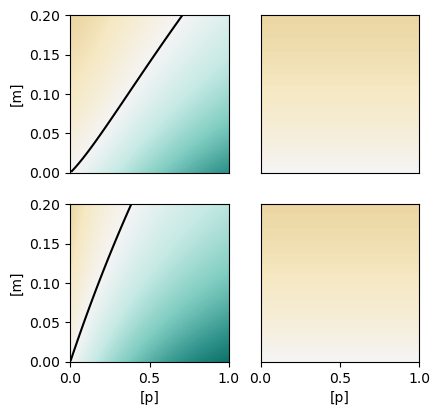

In [5]:
#Plot instantaneous interaction array
fig = plt.figure(figsize=(4.5,4.5))

cLim = 0.4
    
ax1 = fig.add_subplot(221)

ax1.plot(pNullDD,mNullDD,'k')
ax1.imshow(sp1on1.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax1.set_xticks([], [])
ax1.set_ylabel('[m]')

ax2 = fig.add_subplot(222)

ax2.imshow(sp2on1.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax2.set_xticks([], [])
ax2.set_yticks([], [])

ax3 = fig.add_subplot(223)

ax3.plot(pNullCD,mNullCD,'k')
ax3.imshow(sp1on2.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax3.set_xlabel('[p]')
ax3.set_ylabel('[m]')

ax4 = fig.add_subplot(224)

ax4.imshow(sp2on2.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax4.set_yticks([], [])
ax4.set_xlabel('[p]')

### Time and spatial dependencies of interactions
To illustrate how this interaction structure leads to time dependence of interactions in batch culture and spatial dependence in microfluidic chips, we perform simulations of the system dynamics in both types of system. First, batch culture:

In [6]:
#Define function used to generate the values of dY at each timepoint
def batchReact(t, y, Vmax, Kms, Ys, degInvest):    
    
    #The differential for each of these will be calculated separately, and then both joined together to make dY.
    r = y[0:2] #Resource vector
    s1 = y[2] #Population 1 - degrader
    s2 = y[3] #Population 2 - cross-feeder
    
    sens1 = sensFunc(r,0,Kms,Vmaxs,degInvest)
    sens2 = sensFunc(r,1,Kms,Vmaxs,degInvest)
    impact1 = impactFunc(r,0,Vmaxs,Ys,Kms,degInvest)
    impact2 = impactFunc(r,1,Vmaxs,Ys,Kms,degInvest)
    
    dr = impact1*s1 + impact2*s2
    ds1 = sens1*s1
    ds2 = sens2*s2
    
    dY = np.concatenate((dr,np.array([ds1,ds2])),axis=0)
    return dY

In [7]:
B0 = 0.01 #Starting concentration of bacteria in batch (biomass)
P0 = 0.8 #Starting concentration of polymer
M0 = 0 #Starting concentration of breakdown product

tSpan = [0,60]
dt = 0.2

#Time settings for the solver
tSteps = np.arange(tSpan[0],tSpan[1],dt)

inArgs = (Vmaxs, Kms, Ys, degInvest)

batchSol = solve_ivp(fun=batchReact, t_span=tSpan, y0=[P0,M0,B0,B0], t_eval=tSteps, args=inArgs)
Ptime = batchSol.y[0,:]
Mtime = batchSol.y[1,:]
Dtime = batchSol.y[2,:]
Ctime = batchSol.y[3,:]

Next, the spatio-temporal model describing the dynamics of the flow cell:

In [8]:
#Define the module that calculates the diffusive component of the convection-diffusion equation
def diffModule(c,D,dX,bound1,bound2):
    dC = np.zeros(np.size(c))
    for i in range(len(c)):
        if i == 0:
            if bound1 == 'fixed':
                dC[i] = 0
            elif bound1 == 'free':
                dC[i] = D*(-2*c[i+1] + c[i] + c[i+2])/(dX**2)
            elif bound1 == 'noflux':
                dC[i] = D*(-c[i] + c[i+1])/(dX**2)
        elif i == len(c) - 1:
            if bound2 == 'fixed':
                dC[i] = 0
            elif bound2 == 'free':
                dC[i] = D*(-2*c[i-1] + c[i] + c[i-2])/(dX**2)
            elif bound2 == 'noflux':
                dC[i] = D*(-c[i] + c[i-1])/(dX**2)
        else:
            dC[i] = D*(-2*c[i] + c[i+1] + c[i-1])/(dX**2)
    
    return dC
    
#Define the module that calculates the convective component of the convection-diffusion equation
def convectModule(c,V,dX,bound1,bound2):
    dC = np.zeros(np.size(c))
    for i in range(len(c)):
        if i == 0:
            if bound1 == 'fixed':
                dC[i] = 0
            elif bound1 == 'free':
                dC[i] = -V*(c[i+1] - c[i])/dX 
            elif bound1 == 'noflux':
                dC[i] = -V*(c[i] + c[i+1])/2
        elif i == len(c) - 1:
            if bound2 == 'fixed':
                dC[i] = 0
            elif bound2 == 'free':
                dC[i] = V*(c[i-1]-c[i])/dX 
            elif bound2 == 'noflux':
                dC[i] = V*(c[i] + c[i-1])/2
        else:
            dC[i] = V*(c[i-1] - c[i+1])/(2*dX)
            
    return dC

def reactModule(p, m, s1, s2, Vmaxs, Kms, Ys, degInvest, K, mu):
    dS1r = np.zeros(np.size(p))
    dS2r = np.zeros(np.size(p))
    dPr = np.zeros(np.size(p))
    dMr = np.zeros(np.size(p))
    
    for i in range(len(p)):
        r = np.array([p[i],m[i]])
        sens1 = sensFunc(r,0,Kms,Vmaxs,degInvest)
        sens2 = sensFunc(r,1,Kms,Vmaxs,degInvest)
        impact1 = impactFunc(r,0,Vmaxs,Ys,Kms,degInvest)
        impact2 = impactFunc(r,1,Vmaxs,Ys,Kms,degInvest)
    
        dPr[i] = impact1[0]*s1[i]*(1-s1[i]/K) + impact2[0]*s2[i]*(1-s2[i]/K)
        dMr[i] = impact1[1]*s1[i]*(1-s1[i]/K) + impact2[1]*s2[i]*(1-s2[i]/K)
        dS1r[i] = s1[i]*(sens1*(1-s1[i]/K) - mu)
        dS2r[i] = s2[i]*(sens2*(1-s2[i]/K) - mu)
    
        #dPr[i] = impact1[0]*s1[i] + impact2[0]*s2[i]
        #dMr[i] = impact1[1]*s1[i] + impact2[1]*s2[i]
        #dS1r[i] = s1[i]*(sens1 - mu)
        #dS2r[i] = s2[i]*(sens2 - mu)
    
    dPr[0] = 0
    dMr[0] = 0
    
    return (dS1r,dS2r,dPr,dMr)

#Define function used to generate the values of dY at each timepoint
def convectDiff(t, y, dX, Dn, Db, v, Vmaxs, Kms, Ys, degInvest):    
    K = 1 #Channel carrying capacity for both species (separately)
    mu = 0.005 #Washout-induced death rate, proportionality constant multiplied by v
    
    #We have four separate fields: The polymer field p, the monomer field m, and the degrader and cross-feeder fields.
    #The differential for each of these will be calculated separately, and then both joined together to make dY.
    noCells = round(len(y)/4)
    p = y[:noCells] #Polymer
    m = y[noCells:2*noCells] #Monomer
    s1 = y[2*noCells:3*noCells] #Population 1
    s2 = y[3*noCells:] #Population 2
    
    (dS1r,dS2r,dPr,dMr) = reactModule(p, m, s1, s2, Vmaxs, Kms, Ys, degInvest, K, mu*v)
    
    dP = diffModule(p,Dn,dX,'fixed','free') + convectModule(p,v,dX,'fixed','free') + dPr
    dM = diffModule(m,Dn,dX,'fixed','free') + convectModule(m,v,dX,'fixed','free') + dMr
    dS1 = diffModule(s1,Db,dX,'noflux','free') + convectModule(s1,0,dX,'noflux','free') + dS1r
    dS2 = diffModule(s2,Db,dX,'noflux','free') + convectModule(s2,0,dX,'noflux','free') + dS2r
        
    dY = np.concatenate((dP,dM,dS1,dS2),axis=0)
    return dY

In [9]:
#Parameters for the model
dX = 0.5 #Width of a single simulated volume element (mm)
Dn = 0.5 #Diffusion constant of metabolites (mm^2/h) - 4 mm^2/h is approximately the value for benzine
Db = 0 #Diffusion constant of bacteria (mm^2/h)
v = 10 #Velocity of flow (mm/h)

inArgs = (dX,Dn,Db,v,Vmaxs, Kms, Ys, degInvest)

noCells = 61 #Make sure this is odd
szX = noCells*dX

tSpan = [0,1000]
dt = 1

#Initial values for each simulated lattice position and field
initP = np.ones(noCells)*P0
initM = np.ones(noCells)*M0
initS1 = np.ones(noCells)*B0
initS2 = np.ones(noCells)*B0
initConds = np.concatenate((initP,initM,initS1,initS2),axis=0)

#Time settings for the solver
tSteps = np.arange(tSpan[0],tSpan[1],dt)

solBoth = solve_ivp(fun=convectDiff, t_span=tSpan, y0=initConds, t_eval=tSteps, args=inArgs)
Pspace = solBoth.y[:noCells,-1]
Mspace = solBoth.y[noCells:noCells*2,-1]
Dspace = solBoth.y[noCells*2:noCells*3,-1]
Cspace = solBoth.y[noCells*3:noCells*4,-1]

We can plot the resulting environmental trajectories on top of the interaction maps, showing how the changing environmental conditions drives changes in the interaction values (Fig. 4D).

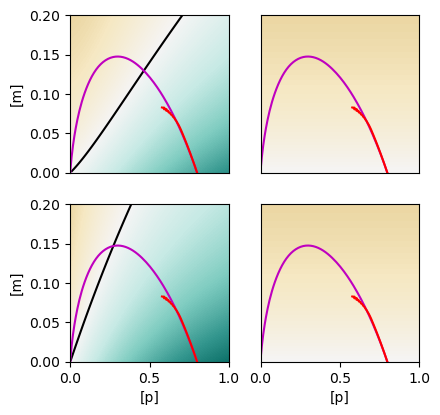

In [10]:
fig = plt.figure(figsize=(4.5,4.5))

ax1 = fig.add_subplot(221)

ax1.plot(pNullDD,mNullDD,'k')
ax1.plot(Ptime,Mtime,'m')
ax1.plot(Pspace,Mspace,'r')
ax1.imshow(sp1on1.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax1.set_xticks([], [])
ax1.set_ylabel('[m]')

ax2 = fig.add_subplot(222)

ax2.imshow(sp2on1.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax2.set_xticks([], [])
ax2.set_yticks([], [])
ax2.plot(Ptime,Mtime,'m')
ax2.plot(Pspace,Mspace,'r')

ax3 = fig.add_subplot(223)

ax3.plot(pNullCD,mNullCD,'k')
ax3.plot(Ptime,Mtime,'m')
ax3.plot(Pspace,Mspace,'r')
ax3.imshow(sp1on2.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax3.set_xlabel('[p]')
ax3.set_ylabel('[m]')

ax4 = fig.add_subplot(224)

ax4.imshow(sp2on2.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax4.set_yticks([], [])
ax4.set_xlabel('[p]')
ax4.plot(Ptime,Mtime,'m')
ax4.plot(Pspace,Mspace,'r')

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\CrossFeedInteractions\\instInteractMatrix.pdf')

Next, we can show the time dependent inter-specific interactions and abundances for the batch culture model (Fig. 4E,F):

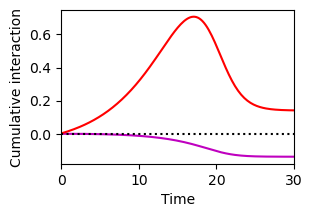

In [11]:
fig = plt.figure(figsize=(3,2))

instInteractDCTime = np.zeros(Ptime.shape)
instInteractCDTime = np.zeros(Ptime.shape)

tSteps = np.arange(0,60,0.2)

for i in range(len(Ptime)):
    r = np.array([Ptime[i],Mtime[i]])
    instInteractDCTime[i] = np.dot(impactFunc(r,1,Vmaxs,Ys,Kms,degInvest),gradSensFunc(r,0,Kms,Vmaxs,degInvest))
    instInteractCDTime[i] = np.dot(impactFunc(r,0,Vmaxs,Ys,Kms,degInvest),gradSensFunc(r,1,Kms,Vmaxs,degInvest))

plt.plot(tSteps,np.cumsum(np.multiply(instInteractDCTime,Ctime)),'m')
plt.plot(tSteps,np.cumsum(np.multiply(instInteractCDTime,Dtime)),'r')
plt.plot([0,60],[0,0],'k:')
ax1=plt.gca()
ax1.set_xlabel('Time')
ax1.set_ylabel('Cumulative interaction')
ax1.set_xlim([0,30])

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\CrossFeedInteractions\\timeGRs.pdf')

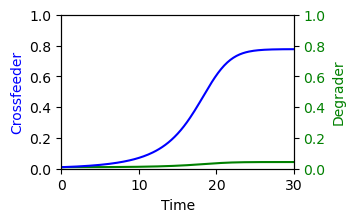

In [12]:
fig = plt.figure(figsize=(3,2))

plt.plot(tSteps,Ctime,color='g')
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(tSteps,Dtime,color='b')
ax1.set_ylim([0,1])
ax2.set_ylim([0,1])
ax1.set_ylabel('Crossfeeder', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel('Degrader', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax1.set_xlabel('Time')
ax1.set_xlim([0,30])

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\CrossFeedInteractions\\timeAbundance.pdf')

And then the spatially-varying interaction strencths and population structure for the flow cell model (Fig. 4G,H):

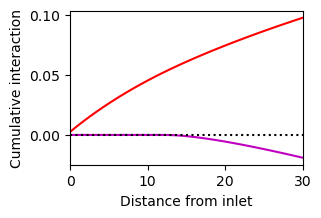

In [13]:
fig = plt.figure(figsize=(3,2))

#Time settings for the solver
xSteps = np.arange(0,szX,dX)

instInteractDCSpace = np.zeros(Pspace.shape)
instInteractCDSpace = np.zeros(Pspace.shape)
instInteractDDSpace = np.zeros(Pspace.shape)
instInteractCCSpace = np.zeros(Pspace.shape)

for i in range(len(Pspace)):
    r = np.array([Pspace[i],Mspace[i]])
    instInteractDCSpace[i] = np.dot(impactFunc(r,1,Vmaxs,Ys,Kms,degInvest),gradSensFunc(r,0,Kms,Vmaxs,degInvest)) #Crossfeeder on degrader
    instInteractCDSpace[i] = np.dot(impactFunc(r,0,Vmaxs,Ys,Kms,degInvest),gradSensFunc(r,1,Kms,Vmaxs,degInvest)) #Degrader on crossfeeder
    instInteractDDSpace[i] = np.dot(impactFunc(r,0,Vmaxs,Ys,Kms,degInvest),gradSensFunc(r,0,Kms,Vmaxs,degInvest)) #Degrader on degrader
    instInteractCCSpace[i] = np.dot(impactFunc(r,1,Vmaxs,Ys,Kms,degInvest),gradSensFunc(r,1,Kms,Vmaxs,degInvest)) #Crossfeeder on crossfeeder
    
    #Need to rescale the instantaneous interactions by the extent to which the channel is filled up with the impactor species to account for the rescaling of the impact function
    #Also need to rescale according to the lattice scale and flow velocity to convert to a timescale
    instInteractDCSpace[i] = instInteractDCSpace[i] * (1-Cspace[i]) * dX/v
    instInteractCDSpace[i] = instInteractCDSpace[i] * (1-Dspace[i]) * dX/v
    instInteractDDSpace[i] = instInteractDDSpace[i] * (1-Dspace[i]) * dX/v
    instInteractCCSpace[i] = instInteractCCSpace[i] * (1-Cspace[i]) * dX/v

cumInteractDCSpace = np.cumsum(np.multiply(instInteractDCSpace,Cspace)*dt)
cumInteractCDSpace = np.cumsum(np.multiply(instInteractCDSpace,Dspace)*dt)
cumInteractDDSpace = np.cumsum(np.multiply(instInteractDDSpace,Dspace)*dt)
cumInteractCCSpace = np.cumsum(np.multiply(instInteractCCSpace,Cspace)*dt)

plt.plot(xSteps,cumInteractDCSpace,'m')
plt.plot(xSteps,cumInteractCDSpace,'r')
#plt.plot(xSteps,cumInteractDDSpace,'k--')
#plt.plot(xSteps,cumInteractCCSpace,'k-.')
plt.plot([0,szX],[0,0],'k:')
ax1 = plt.gca()
ax1.set_xlabel('Distance from inlet')
ax1.set_ylabel('Cumulative interaction')
ax1.set_xlim([0,30])

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\CrossFeedInteractions\\spaceGRs.pdf')

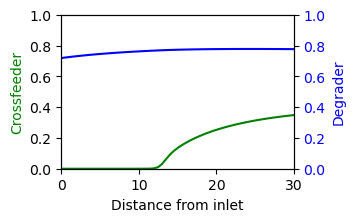

In [14]:
fig = plt.figure(figsize=(3,2))

plt.plot(xSteps,Cspace,'g')
ax1 = plt.gca()
ax2 = ax1.twinx()
plt.plot(xSteps,Dspace,'b')
ax1.set_ylim([-0,1])
ax2.set_ylim([-0,1])
ax1.set_ylabel('Crossfeeder', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylabel('Degrader', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel('Distance from inlet')
ax1.set_xlim([0,30])

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\CrossFeedInteractions\\spaceAbundances.pdf')

We can also make sure that the cumulative interaction for the spatial model is accurately defined by calculating its value based on the integral of the instantaneous interaction over the spatial trajectory in the environment space and comparing to the actual growth rate impact based on the sensitivity function:

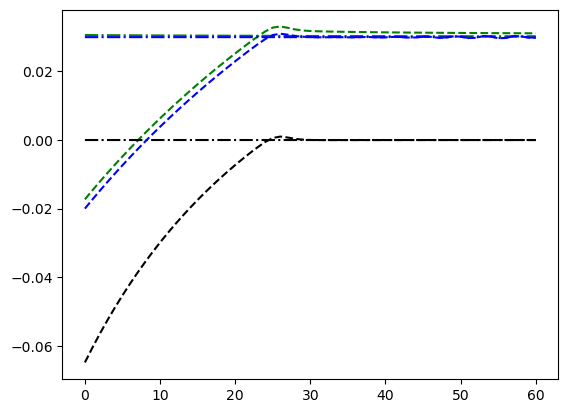

In [15]:
#Validation plot: the following pairs of lines should (approximately) fall on top of each other at steady-state. 
#First is the cumulative interaction plus base growth rate, second is the measured growth rate, third is the sensitivity function
#Note that the overlap between the first and other curves will break down if the Peclet number is low (typically if D is of a similar size to v)

#Predicted GR of cross-feeder (dashed)
predGR_C = np.multiply(cumInteractCCSpace + cumInteractCDSpace + sensFunc([P0,M0],1,Kms,Vmaxs,degInvest),(1-Cspace)) - 0.02
plt.plot(predGR_C,'g--')
#Predicted GR of degrader (dot dash)
predGR_D = np.multiply(cumInteractDCSpace + cumInteractDDSpace + sensFunc([P0,M0],0,Kms,Vmaxs,degInvest),(1-Dspace)) - 0.02
plt.plot(predGR_D,'g-.')
#Actual GR of cross-feeder
actGR_C = np.divide(solBoth.y[noCells*3:noCells*4,-1] - solBoth.y[noCells*3:noCells*4,-11],Cspace)/(10*dt)
plt.plot(actGR_C,'k--')
#Actual GR of degrader
actGR_D = np.divide(solBoth.y[noCells*2:noCells*3,-1] - solBoth.y[noCells*2:noCells*3,-11],Dspace)/(10*dt)
plt.plot(actGR_D,'k-.')
#GR of both species as calculated via sensitivity functions
sensGR_C = np.zeros(predGR_D.shape)
sensGR_D = np.zeros(predGR_C.shape)
for i in range(len(predGR_C)):
    r = np.array([Pspace[i],Mspace[i]])
    sensGR_D[i] = sensFunc(r,0,Kms,Vmaxs,degInvest)*(1-Dspace[i]) - 0.02
    sensGR_C[i] = sensFunc(r,1,Kms,Vmaxs,degInvest)*(1-Cspace[i]) - 0.02
plt.plot(sensGR_C,'b--')
plt.plot(sensGR_D,'b-.')

Now we can check that the patterns of abundance and degrader/cross-feeder separation in the flow cells as a function of flow velocity match the experimental trends (Fig. S8)

C:\Users\omeacock\AppData\Local\Temp\ipykernel_14212\1721623286.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Reds')


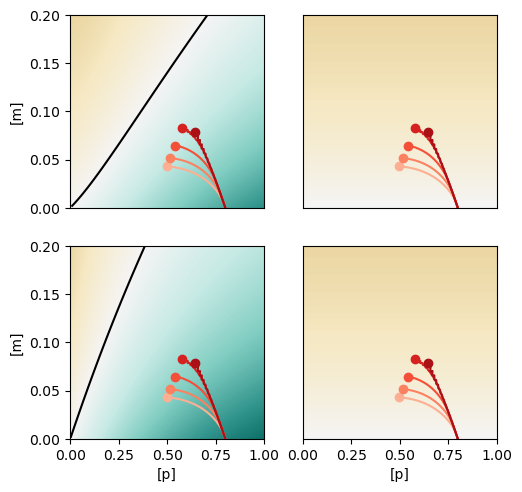

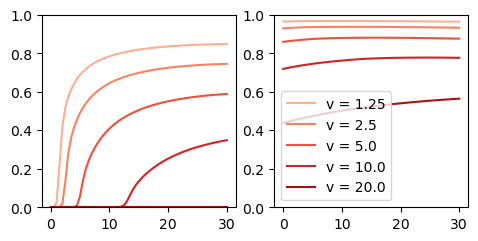

In [16]:
fig1 = plt.figure(figsize=(5.5,5.5))
fig2 = plt.figure(figsize=(5.5,2.5))

ax1 = fig1.add_subplot(221)

ax1.plot(pNullDD,mNullDD,'k')
ax1.imshow(sp1on1.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax1.set_xticks([], [])
ax1.set_ylabel('[m]')

ax2 = fig1.add_subplot(222)

ax2.imshow(sp2on1.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax2.set_xticks([], [])
ax2.set_yticks([], [])

ax3 = fig1.add_subplot(223)

ax3.plot(pNullCD,mNullCD,'k')
ax3.imshow(sp1on2.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax3.set_xlabel('[p]')
ax3.set_ylabel('[m]')

ax4 = fig1.add_subplot(224)

ax4.imshow(sp2on2.T,cmap='BrBG',aspect='auto',vmin = -cLim, vmax = cLim,extent=[0,maxP,0,maxM], origin='lower')
ax4.set_yticks([], [])
ax4.set_xlabel('[p]')

ax5 = fig2.add_subplot(121)
ax6 = fig2.add_subplot(122)

vList = np.array([1.25,2.5,5,10,20]) #Velocity of flow (mm/h)

tSpan = [0,1000]
dt = 1
#Time settings for the solver
tSteps = np.arange(tSpan[0],tSpan[1],dt)

cmap = matplotlib.cm.get_cmap('Reds')

abundances = np.zeros(vList.shape)
lambdas = np.zeros(vList.shape)

for i in range(len(vList)):
    inArgs = (dX,Dn,Db,vList[i],Vmaxs, Kms, Ys, degInvest)
    
    solBoth = solve_ivp(fun=convectDiff, t_span=tSpan, y0=initConds, t_eval=tSteps, args=inArgs)
    Pspace = solBoth.y[:noCells,-1]
    Mspace = solBoth.y[noCells:noCells*2,-1]
    Dspace = solBoth.y[noCells*2:noCells*3,-1]
    Cspace = solBoth.y[noCells*3:noCells*4,-1]

    ax1.plot(Pspace,Mspace,color=cmap((i+2)/(len(vList)+2)))
    ax2.plot(Pspace,Mspace,color=cmap((i+2)/(len(vList)+2)))
    ax3.plot(Pspace,Mspace,color=cmap((i+2)/(len(vList)+2)))
    ax4.plot(Pspace,Mspace,color=cmap((i+2)/(len(vList)+2)))
    
    ax1.plot(Pspace[-1],Mspace[-1],'o',color=cmap((i+2)/(len(vList)+2)))
    ax2.plot(Pspace[-1],Mspace[-1],'o',color=cmap((i+2)/(len(vList)+2)))
    ax3.plot(Pspace[-1],Mspace[-1],'o',color=cmap((i+2)/(len(vList)+2)))
    ax4.plot(Pspace[-1],Mspace[-1],'o',color=cmap((i+2)/(len(vList)+2)))
    
    ax5.plot(xSteps,Cspace,color=cmap((i+2)/(len(vList)+2)))
    ax6.plot(xSteps,Dspace,color=cmap((i+2)/(len(vList)+2)),label='v = ' + str(vList[i]))
    
    #Store abundance and positional data for cross-feeder
    abundances[i] = np.sum(Cspace) * dX
    lambdas[i] = xSteps[np.argmax(Cspace > max(Cspace)/2)]

ax1.set_xlim([0,maxP])
fig1.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\CrossFeedInteractions\\diffFlowsInstInts.pdf')

ax5.set_ylim([0,1])
ax6.legend(loc='lower left')
ax6.set_ylim([0,1])

fig2.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\CrossFeedInteractions\\diffFlows.pdf')

C:\Users\omeacock\AppData\Local\Temp\ipykernel_14212\379726864.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Reds')


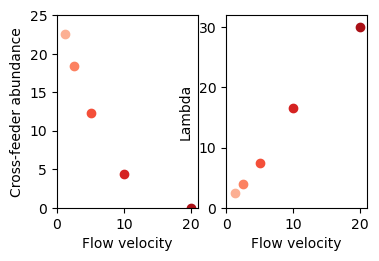

In [17]:
cmap = matplotlib.cm.get_cmap('Reds')

fig = plt.figure(figsize=(4,2.5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(len(vList)):
    ax1.plot(vList[i],abundances[i],'o',color=cmap((i+2)/(len(vList)+2)))
    ax2.plot(vList[i],lambdas[i],'o',color=cmap((i+2)/(len(vList)+2)))

ax1.set_ylim([0,25])
ax1.set_xlim([0,21])

ax1.set_xlabel('Flow velocity')
ax1.set_ylabel('Cross-feeder abundance')

ax2.set_ylim([0,32])
ax2.set_xlim([0,21])

ax2.set_xlabel('Flow velocity')
ax2.set_ylabel('Lambda')

fig.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\CrossFeedInteractions\\abundancesLambdas.pdf')

We also need to check that the spatio-temporal dynamics settle down over long timescales to a steady-state. Below, we check that this is the case first for the environmental composition and then for the distribution of species along the channel.

C:\Users\omeacock\AppData\Local\Temp\ipykernel_14212\699504715.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')


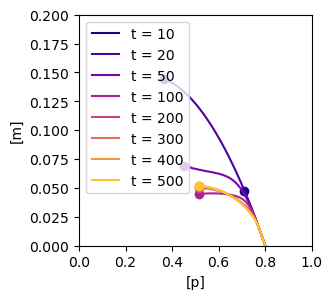

In [18]:
fig1 = plt.figure(figsize=(3,3))
ax1 = plt.gca()

inArgs = (dX,Dn,Db,2.5,Vmaxs, Kms, Ys, degInvest)

tList = np.array([10,20,50,100,200,300,400,500]) #Times at which model will be sampled and shown

cmap = matplotlib.cm.get_cmap('plasma')

for i in range(len(tList)):
    tSpan = [0,tList[i]]
    dt = 1
    #Time settings for the solver
    tSteps = np.arange(tSpan[0],tSpan[1],dt)
    
    solBoth = solve_ivp(fun=convectDiff, t_span=tSpan, y0=initConds, t_eval=tSteps, args=inArgs)
    Pspace = solBoth.y[:noCells,-1]
    Mspace = solBoth.y[noCells:noCells*2,-1]
    Dspace = solBoth.y[noCells*2:noCells*3,-1]
    Cspace = solBoth.y[noCells*3:noCells*4,-1]
    
    ax1.plot(Pspace,Mspace,color=cmap(i/len(tList)),label='t = ' + str(tList[i]))    
    ax1.plot(Pspace[-1],Mspace[-1],'o',color=cmap(i/len(tList)))
    
ax1.legend()
ax1.set_ylim([0,0.2])
ax1.set_xlim([0,1])
ax1.set_xlabel('[p]')
ax1.set_ylabel('[m]')

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\CrossFeedInteractions\\timeStabilisation.pdf')

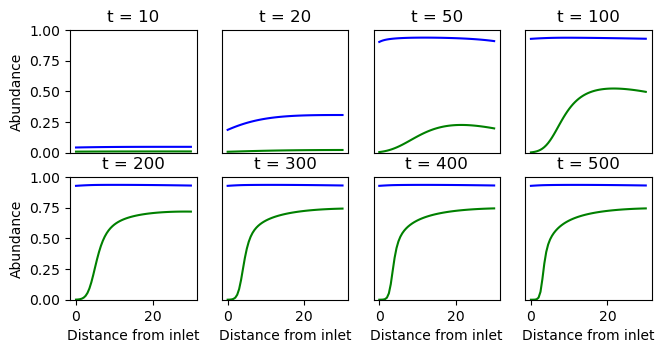

In [19]:
fig1 = plt.figure(figsize=(7.5,3.5))

for i in range(len(tList)):
    tSpan = [0,tList[i]]
    dt = 1
    #Time settings for the solver
    tSteps = np.arange(tSpan[0],tSpan[1],dt)
    
    solBoth = solve_ivp(fun=convectDiff, t_span=tSpan, y0=initConds, t_eval=tSteps, args=inArgs)
    Dspace = solBoth.y[noCells*2:noCells*3,-1]
    Cspace = solBoth.y[noCells*3:noCells*4,-1]
    
    ax = fig1.add_subplot(2,4,i + 1)
    
    ax.plot(xSteps,Dspace,color='b')
    ax.plot(xSteps,Cspace,color='g')
    ax.set_ylim([0,1])

    if (i != 0) and (i != 4):
        ax.set_yticks([],[])
    else:
        ax.set_ylabel('Abundance')
    if (i < 4):
        ax.set_xticks([],[])
    else:
        ax.set_xlabel('Distance from inlet')
        
    ax.set_title('t = ' + str(tList[i]))

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\CrossFeedInteractions\\timeStabilisationExample.pdf')

C:\Users\omeacock\AppData\Local\Temp\ipykernel_14212\3234609008.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = matplotlib.cm.get_cmap('Greens')
C:\Users\omeacock\AppData\Local\Temp\ipykernel_14212\3234609008.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = matplotlib.cm.get_cmap('Blues')


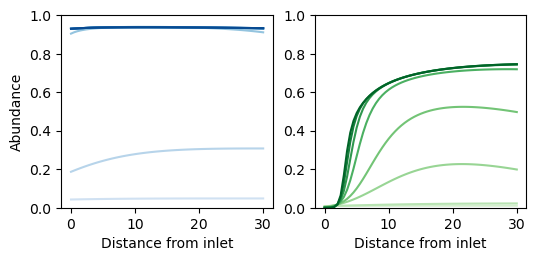

In [20]:
fig1 = plt.figure(figsize=(6,2.5))
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)

cmap1 = matplotlib.cm.get_cmap('Greens')
cmap2 = matplotlib.cm.get_cmap('Blues')

for i in range(len(tList)):
    tSpan = [0,tList[i]]
    dt = 1
    #Time settings for the solver
    tSteps = np.arange(tSpan[0],tSpan[1],dt)
    
    solBoth = solve_ivp(fun=convectDiff, t_span=tSpan, y0=initConds, t_eval=tSteps, args=inArgs)
    Dspace = solBoth.y[noCells*2:noCells*3,-1]
    Cspace = solBoth.y[noCells*3:noCells*4,-1]
    
    ax1.plot(xSteps,Dspace,color=cmap2((i+2)/(len(tList)+2)))
    ax2.plot(xSteps,Cspace,color=cmap1((i+2)/(len(tList)+2)))

ax1.set_ylim([0,1])
ax2.set_ylim([0,1])

ax1.set_xlabel('Distance from inlet')
ax2.set_xlabel('Distance from inlet')
ax1.set_ylabel('Abundance')

fig1.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\CrossFeedInteractions\\timeStabilisationExample.pdf')